# Project scoping

The goal of this project is to predict the likelihood of default credit card payments using customers' attributes (such as sex, education, age, etc) and their past credit card bill and payment history. We build a binary classification model using the UCI credit card dataset, where the binary response variable is 0 (no default payment next month) or 1 (default payment next month).

In the context of Credit Sesame's product, building a model that can predict future credit card default payments given a customer's profile and credit card history is very useful, since default customers will see their credit scores lowered and therefore could greatly benefit from becoming Credit Sesame's customers. By building this model, we can identify credit card holders that potentially need to rebuild their credit score because of default payments and direct our marketing efforts to convert these credit card holders into Credit Sesame's customers.

The project is broken down into the following steps:
- data acquisition and exploratory data analysis
- data cleaning, feature engineering, and dataset preparation
- model training and model performance evaluation
- inference (i.e. generation of predictions) on unseen data using best model.

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report

# Load data

We know that the UCI dataset is small enough that we can download it locally and load it into memory. We do not need to worry about storing and fetching it from cloud storage (e.g. AWS S3 bucket).

In [2]:
# load dataset
credit_card_df = pd.read_excel('./default of credit card clients.xls', skiprows=[0])

In [3]:
# check head
credit_card_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Exploratory data analysis

We perform some initial EDA to understand the data and investigate whether there are any evident errors or inconsistencies with the Attribute Information on the UCI website.

In [4]:
credit_card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [5]:
credit_card_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


We observe the following:
- **ID**: non-predictive feature. We will drop it when building the feature set for the model.
- **LIMIT_BAL**: no missing values. As it could be expected, large variability (by looking at the range of values). Additionally, the credit limit of a customer can change over time. Therefore, are we under the assumption that the credit limit doesn't change over the timeframe considered (April-September 2015) or does this column refer to the final credit limit after September 2015?
- **SEX**: no missing values, binary attribute [1,2] as expected.
- **EDUCATION**: no missing values. However, from the Attribute Information on the UCI website this variable should only take values of [1,2,3,4] so a minimum of 0 and maximum of 6 are problematic. Needs further investigation. Additionally, what happens if a customer changes their education status during the time frame considered (April-September 2015)? Does this column refer to the education status after September 2015?
- **MARRIAGE**: no missing values, but a minimum of 0 contradicts what is written in the Attribute Information. Needs further investigation. Additionally, what happens if a customer changes their marriage status during the time frame considered (April-September 2015)? Does this column refer to the marriage status after September 2015?
- **AGE**: no missing values, range seems reasonable. Does this column refer to the customer's age after September 2015?
- **[PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6]**: minimum value of -2 and maximum of 8, while Attribute Info says possible values of [-1]+[1,...,9].
- **[BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, BILL_AMT6]**: ranges seem sensible (with negative mimimum values, which can happen in credit card balances).
- **[PAY_AMT1, PAY_AMT2, PAY_AMT3, PAY_AMT4, PAY_AMT5, PAY_AMT6]**: ranges seem sensible (with minimum values of 0). One question about this feature: for instance, from the Attribute Information we know that PAY_AMT1 refers to amount paid in September 2015. Does this mean amount paid in September 2015 towards the September 2015 bill statement or towards the previous bill statement (August 2015)? This feature needs to be defined and understood more precisely.
- **default payment next month**: no missing values, binary [0,1] as expected.

Let's look into some of these features more, starting with the distribution of the **SEX** feature:

In [6]:
# percentage of 2 (females) and 1 (males) in dataset
credit_card_df['SEX'].value_counts()/len(credit_card_df['SEX'])

2    0.603733
1    0.396267
Name: SEX, dtype: float64

Tha dataset has an imbalance towards 2 (female). In a real-world scenario, we would want to have a dataset that is as balanced as possible to avoid building an unfair model that perpetuates societal biases. Let's look at the distribution of the target variable between male and female:

In [7]:
# percentage of females with default payment next month
sum(credit_card_df[credit_card_df['SEX']==2]['default payment next month'])/len(credit_card_df[credit_card_df['SEX']==2])

0.20776280918727916

In [8]:
# percentage of males with default payment next month
sum(credit_card_df[credit_card_df['SEX']==1]['default payment next month'])/len(credit_card_df[credit_card_df['SEX']==1])

0.2416722745625841

We observe a pretty balanced distribution of default payments between males and females, which means that the dataset does not contain a strong bias in this respect. Let's move on to **EDUCATION**:

In [9]:
credit_card_df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

This distribution is problematic since, as we mentioned above, this variable should contain only four distinct values. In a real-world scenario, we would need to investigate what these seven distinct values correspond to by understanding how this data was logged and converted into this dataset. Do any of these values actually indicate missing values (e.g. 0 might indicate that we have no education info for those customers)?

The same occurs for the **MARRIAGE** variable:

In [10]:
credit_card_df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

Does 0 mean no marital status info? This needs to be investigated further by looking at how the dataset was created.

The same happens for the **PAY_n** (n=0,2,3,4,5,6) features. They have eleven distinct values, from -2 to 8, in contrast with Attribute Info, which says that the ten possible values are -1 and [1,...,9]. Could it be that the observed value of -2 actually corresponds to -1 and the observed [0,...,8] values actually correspond to [1,...,9]? Would the observed value of 0 actually indicate a missing value? This is only an hypothesis and we would need to investigate further to understand why we observe this range of values for these variables.

In [11]:
credit_card_df['PAY_0'].value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_0, dtype: int64

Finally, we can quickly get a rough idea of the correlations between variables by computing the Spearman rank correlations (which is a more appropriate measure than Pearson's correlation for discrete variables):

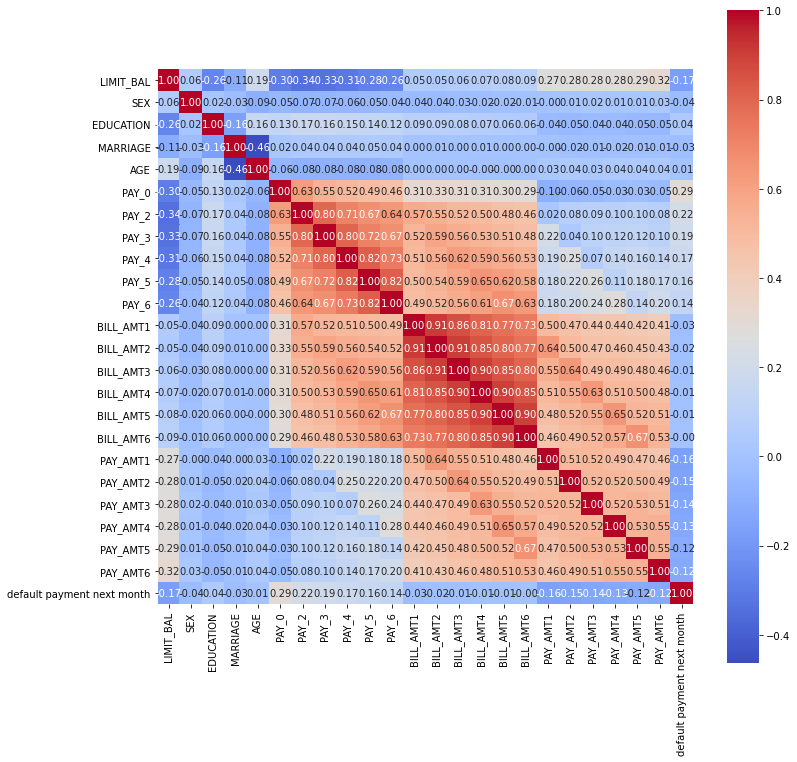

In [12]:
# heatmap of Spearman rank correlations between variables in dataset
plt.figure(figsize=(12,12))
sns.heatmap(credit_card_df.drop(['ID'],axis=1).corr(method='spearman'), square=True, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

We observe quite strong correlations among the BILL_AMT variables, among the PAY variables, between PAY and BILL_AMT variables, and between BILL_AMT and PAY_AMT variables. This suggests that we might not want to include all of these correlated variables into our model, but rather engineer some aggregate features and thus reduce the dimensionality of the problem.

We finish this section by checking the distribution of the binary target variable:

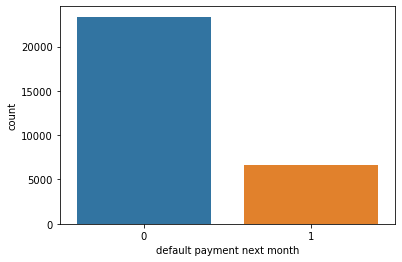

In [13]:
sns.countplot(x='default payment next month', data=credit_card_df)
plt.show()

In [14]:
# percentages
credit_card_df['default payment next month'].value_counts()/len(credit_card_df)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

We observe that the target variable is highly imbalanced towards the no default payment class (majority class), as it could be expected since most customers pay their credit card balance on time.

# Feature engineering & dataset preparation

We can think of engineering additional features that might be highly predictive of the response variable to include in our model. As an example, here we introduce the ratio between bill amount for each month and credit limit. In most cases, these monthly variables (called **PC_BILL_AMT**) will be numbers between 0 and 1, but we can expect a few negative values (when the bill statement is negative) and a few values larger than 1 (when customers accumulate interests on past bills and therefore subsequent due bill amounts can become larger than their credit limits). The idea behind introducing these features is that customers with a history of large ratios (i.e. large percentage of credit limit used) might be more likely to default next month. In a real-world scenario we could certainly spend more time trying to come up with other engineered features to include in the model.

In [15]:
# create PC_BILL_AMT monthly features
bill_cols = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']
for col in bill_cols:
    credit_card_df['PC_'+col] = credit_card_df[col]/credit_card_df['LIMIT_BAL']

All the categorical features present in the dataset so far (SEX, EDUCATION, MARRIAGE, PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6) have been naturally label encoded. We might be interested in **one-hot encoding** them instead (although this greatly increases the dimensionality of the feature set). To do so, we can just uncomment the line below:

In [16]:
categorical_features = ['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']

# uncomment line below for categorical one-hot encoding
# credit_card_df = pd.get_dummies(credit_card_df, columns=categorical_features, drop_first=True)

For this assignment, we keep the **label encoding** by default, since we explicitly verified that one-hot encoding does not improve the performance of the model built in the next section. In addition, as we mentioned earlier, all categorical features except SEX appear in the dataset with more distinct values than what is described on the UCI website. In a real-world scenario, it would be paramount to understand what all the observed values correspond to, fix any mistakes, and deal with any missing values. Once this is done, it would be interesting to think of more features to engineer starting from these categorical variables (especially the PAY_n variables). In the absence of more precise and consistent information about these attributes, we simply keep them as they are in the dataset.

Finally, we observed earlier that the dataset is highly imbalanced towards the no default payment class. This means that any model we build will inherently have a harder time learning how to predict default payment events than no default payment events. To fix this, we could explore majority undersampling or minority oversampling techniques to balance the dataset among the two classes. Popular techniques for **minority oversampling** are random oversampling (randomly duplicate data points belonging to the minority class and add them to the training dataset) and SMOTE (synthetize new data points belonging to the minority class). If we had more time to dedicate to this project (beyond the suggested 2-4 hours), these would certainly be interesting directions to pursue.

We drop the non-predictive ID column and create feature and target sets:

In [17]:
# create feature set: drop ID, target, and BILL_AMT columns
cols_to_drop = ['ID','default payment next month']+bill_cols
credit_card_features_df = credit_card_df.drop(cols_to_drop,axis=1)

# create target set
credit_card_target_df = credit_card_df[['default payment next month']]

We perform a conventional 80-20 train-test split:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(credit_card_features_df, credit_card_target_df, test_size = 0.2, random_state = 42)

# Modeling

For the purpose of this project, we choose **random forest** as the classification model to predict default payment customers. We use 5-fold grid-search cross validation to train the model, validate it, and find the best combination of hyperparameters that maximizes model performance. To evaluate the model performance, we choose **recall** as the KPI. I believe that in the context of this project and its use case for Credit Sesame, recall is the most important metric to monitor. Recall tells us the percentage of actual default payment events in the dataset that the model predicts as such (i.e. true positives divided by the sum of true positives and false negatives). In the project scoping part of this assignment, we said that we would like to identify all likely-to-default customers so that we can target them and hopefully convert them into Credit Sesame customers. This means that we want to build a model with the lowest possible number of false negatives (default customers predicted as non-default) and, in other words, the higher possible recall. We therefore use recall as the scoring metric in our grid search cross validation.

## Random forest

In [19]:
# hyperparameters to explore
param_grid = {'n_estimators': [100,150,200,250], 'max_depth': [10,15,20,25]}

# define grid search CV
CV_rf = GridSearchCV(estimator=RandomForestClassifier(), 
                     param_grid=param_grid, 
                     cv=5, 
                     scoring='recall', 
                     n_jobs=-1)

# train RF model
CV_rf.fit(X_train,y_train.values.ravel())

# print best metric and best parameters
print('Highest validation recall: ',CV_rf.best_score_)
print('Best hyperparameters: ', CV_rf.best_params_)

Highest validation recall:  0.3691552825726287
Best hyperparameters:  {'max_depth': 25, 'n_estimators': 150}


In [20]:
# train model with best parameters
rf = RandomForestClassifier(max_depth = CV_rf.best_params_['max_depth'],
                            n_estimators = CV_rf.best_params_['n_estimators'],
                            n_jobs=-1,
                            random_state = 42)
rf_fitted_model = rf.fit(X_train,y_train.values.ravel())

In [21]:
# generate predictions on train set
y_train_rf_pred = rf.predict(X_train)

In [22]:
# print train confusion matrix (false negatives is element [1,0])
confusion_matrix(y_train, y_train_rf_pred)

array([[18673,     4],
       [  283,  5040]])

In [23]:
# print train classification report
print(classification_report(y_train, y_train_rf_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18677
           1       1.00      0.95      0.97      5323

    accuracy                           0.99     24000
   macro avg       0.99      0.97      0.98     24000
weighted avg       0.99      0.99      0.99     24000



We can look at feature importance to understand what features are highly predictive of default payment customers:

In [24]:
# feature importance
values = sorted(zip(X_train.columns, rf_fitted_model.feature_importances_), key=lambda x: -x[1])
values

[('PAY_0', 0.10629296879576501),
 ('PC_BILL_AMT1', 0.0612638504601708),
 ('PC_BILL_AMT2', 0.056917513945103256),
 ('AGE', 0.056823723037081886),
 ('PC_BILL_AMT3', 0.05456488208262203),
 ('PC_BILL_AMT6', 0.052847150013288845),
 ('PC_BILL_AMT5', 0.05213207464923171),
 ('PC_BILL_AMT4', 0.05201243598835864),
 ('PAY_AMT1', 0.051566531454981544),
 ('LIMIT_BAL', 0.04930364659327345),
 ('PAY_AMT2', 0.04777759616827317),
 ('PAY_AMT3', 0.04616485667487211),
 ('PAY_AMT6', 0.04437576660535389),
 ('PAY_AMT4', 0.04424217204228153),
 ('PAY_AMT5', 0.04371323464861314),
 ('PAY_2', 0.0425743643733601),
 ('PAY_4', 0.027488580742632517),
 ('PAY_3', 0.025241897479344782),
 ('PAY_6', 0.021954573618330867),
 ('PAY_5', 0.020046180865299336),
 ('EDUCATION', 0.01891348567441246),
 ('MARRIAGE', 0.01289118422488561),
 ('SEX', 0.010891329862463276)]

We see that the most important features are PAY_0, AGE, and the PC_BILL_AMT features we engineered. On the other hand, it's interesting to observe that EDUCATION, MARRIAGE, and SEX are not very predictive features.

# Predictions on unseen test set

In [25]:
# use best model to generate predictions on unseen test set
y_test_rf_pred = rf.predict(X_test)

In [26]:
# print test confusion matrix
confusion_matrix(y_test, y_test_rf_pred)

array([[4443,  244],
       [ 847,  466]])

In [27]:
# print test classification report
print(classification_report(y_test, y_test_rf_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.66      0.35      0.46      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



# Final remarks

We can compare the classification report on the train and test sets. We see that the random forest model we built is highly **overfitting** the data, since it has a 0.95 recall on the train set, but only 0.35 on the unseen test set. The percentage of false negatives is only 1.2% in the train set, but 14.1% in the test set. Despite the rather poor out-of-sample performance, we have now built a model that can be used to predict the likelihood of default credit card payments, given a customer's profile and recent credit card history.

If we had more time to dedicate to this project (beyond the suggested 2-4 hours), here are a few things we could explore to improve the overall model performance:
- reduce overfitting of the random forest model (e.g. hyperparameter tuning, pruning, etc)
- engineer additional features (especially involving the PAY_n features once they are clearly understood)
- explore minority oversampling techniques to balance the dataset
- train and compare additional models (e.g. logistic regression, gradient boosted trees)
- perform extensive hyperparameter grid search for tree-based models.

This was a fun assignment!